# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
import random
import os

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors


# Optional: Set style for plots
sns.set(style="whitegrid")

# %matplotlib inline (for notebook environments only)

# Load embeddings and game dataframe

We load the final embedding matrix and the corresponding game dataframe.  
The embeddings are normalized and will be used directly for clustering.  
We also check the dimensions to make sure the rows align.

In [2]:
# Load embeddings and game metadata
emb_norm = np.load("../data/embeddings_FINAL.npy") 
df = pd.read_pickle("../data/games_df_FINAL.pkl")

# Check shapes
print("Embeddings shape:", emb_norm.shape)
print("Games dataframe shape:", df.shape)

Embeddings shape: (10476, 384)
Games dataframe shape: (10476, 11)


# Helper Functions

In [3]:
def track_memory_and_time(func):
    """
    Decorator to track memory usage and execution time of a function
    """
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        start_time = time.time()
        result = func(*args, **kwargs)
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        elapsed = time.time() - start_time
        print(f"Time: {elapsed:.2f} seconds | Peak memory: {peak / 1024**2:.2f} MB")
        return result
    return wrapper

In [4]:
def inspect_clusters(df, cluster_col="cluster_kmeans", n_clusters=4, n_samples=5, display_cols=None):
    """
    Print sample games from selected clusters.
    
    Always includes cluster 0 (if it exists), and randomly selects the remaining.
    """
    if display_cols is None:
        display_cols = ["name", "summary", "genres", "platforms"]
    
    unique_clusters = sorted(df[cluster_col].dropna().unique())
    
    if len(unique_clusters) == 0:
        print("No clusters found.")
        return
    
    clusters_to_show = []
    if 0 in unique_clusters:
        clusters_to_show.append(0)
        remaining_clusters = [c for c in unique_clusters if c != 0]
    else:
        remaining_clusters = unique_clusters
    
    random.seed(42)
    clusters_to_show += random.sample(remaining_clusters, min(n_clusters - len(clusters_to_show), len(remaining_clusters)))
    clusters_to_show = sorted(df[cluster_col].dropna().unique())

    for cluster_id in clusters_to_show:
        print("=" * 80)
        count = df[df[cluster_col] == cluster_id].shape[0]
        print(f"Cluster {cluster_id} — {count} games")
        print("=" * 80)
        
        sample = df[df[cluster_col] == cluster_id][display_cols].sample(n=min(n_samples, count), random_state=42)
        display(sample)

In [5]:
def evaluate_clustering(X, labels):
    """
    Compute Silhouette and Davies-Bouldin scores
    """
    if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
        print("Not enough clusters for evaluation")
        return None, None

    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies–Bouldin Index: {db_index:.4f}")

In [6]:
def plot_clusters(X, labels, title="Cluster Plot", figsize=(8,6), save_path="../data"):
    """
    Plot clustering results using both PCA and t-SNE for visualization.
    Saves plots in PNG format inside the specified folder.
    """
    os.makedirs(save_path, exist_ok=True)  # Ensure output folder exists
    fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]))

    # PCA projection
    pca = PCA(n_components=2)
    reduced_pca = pca.fit_transform(X)
    scatter_pca = axs[0].scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=labels, cmap="Set1", alpha=0.7)
    axs[0].set_title("PCA Projection")
    axs[0].set_xlabel("PCA 1")
    axs[0].set_ylabel("PCA 2")
    fig.colorbar(scatter_pca, ax=axs[0])

    # t-SNE projection
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_tsne = tsne.fit_transform(X)
    scatter_tsne = axs[1].scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=labels, cmap="Set1", alpha=0.7)
    axs[1].set_title("t-SNE Projection")
    axs[1].set_xlabel("t-SNE 1")
    axs[1].set_ylabel("t-SNE 2")
    fig.colorbar(scatter_tsne, ax=axs[1])

    # Save plots
    filename_base = title.lower().replace(" ", "_")
    png_path = os.path.join(save_path, f"{filename_base}.png")
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(png_path, dpi=300)
    print(f"Plot saved to: {png_path}")

    plt.show()

# Apply KMeans Clustering

We apply the KMeans clustering algorithm on the normalized embeddings.  
We choose a number of clusters `k = 20` based on the approximate size and diversity of the dataset.  
After fitting the model, we assign each game to a cluster.

In [7]:
df_kmeans = df.copy()

##### Determine Optimal Number of Clusters with Elbow Method

To identify the most suitable number of clusters for KMeans, we use the **Elbow Method**.

This method involves the following steps:

1. We run **KMeans** for different values of k (number of clusters).
2. For each k, we compute the **inertia**, which is the within-cluster sum of squared distances (SSE).
3. We plot k versus inertia. The optimal k is typically at the "elbow" point — where the inertia starts decreasing more slowly.

This helps us balance between underfitting (too few clusters) and overfitting (too many clusters), and choose a value of k that offers a good trade-off between compactness and efficiency.

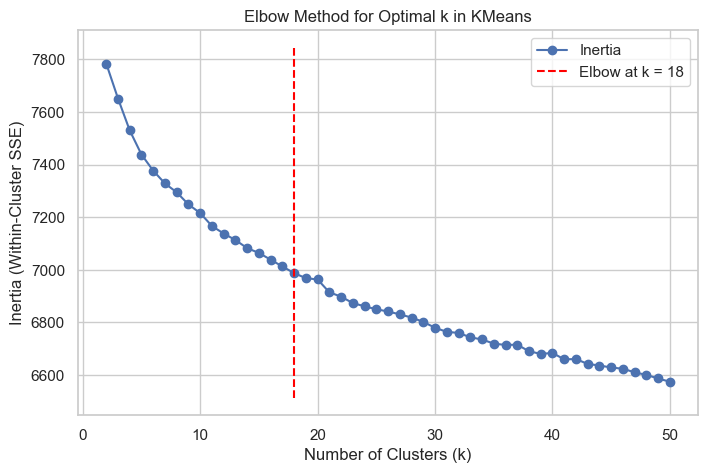

Optimal number of clusters (k) found by Elbow Method: 18


In [8]:
# Compute inertias for different k
inertias = []
k_values = list(range(2, 51))  # k from 2 to 50

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(emb_norm)
    inertias.append(kmeans.inertia_)

# Detect elbow point automatically
knee = KneeLocator(k_values, inertias, curve="convex", direction="decreasing")
k_optimal = knee.elbow

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', label="Inertia")
plt.vlines(k_optimal, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f"Elbow at k = {k_optimal}")
plt.title("Elbow Method for Optimal k in KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.grid(True)
plt.legend()
plt.show()

# Report optimal k
print(f"Optimal number of clusters (k) found by Elbow Method: {k_optimal}")

In [9]:
@track_memory_and_time
def run_kmeans_clustering(X, n_clusters=20, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
    labels = kmeans.fit_predict(X)
    return labels

# Run KMeans
kmeans_labels = run_kmeans_clustering(emb_norm, n_clusters=k_optimal)

# Assign to dataframe
df_kmeans["cluster_kmeans"] = kmeans_labels

# Check basic cluster stats
print("Number of clusters found:", df_kmeans["cluster_kmeans"].nunique())
print(df_kmeans["cluster_kmeans"].value_counts().sort_index())

Time: 0.22 seconds | Peak memory: 30.73 MB
Number of clusters found: 18
cluster_kmeans
0     810
1     666
2     785
3     341
4     993
5     428
6     554
7     416
8     602
9     443
10    651
11    643
12    798
13    306
14    500
15    394
16    524
17    622
Name: count, dtype: int64


### Inspect KMeans Clusters

Let's look at a few clusters found by KMeans and inspect some sample games from each cluster.  
We display the name, summary, genres, and platforms to evaluate the internal coherence of the clusters.

In [10]:
inspect_clusters(df_kmeans, cluster_col="cluster_kmeans")

Cluster 0 — 810 games


,name,summary,genres,platforms
2954,Hitman 3: Chongqing,Under the flickering neon lights of busy cafes...,Adventure,PC (Microsoft Windows)
8387,Golden Rails: World's Fair,The mayor of your hometown needs your help con...,"Adventure, Indie, Strategy",PC (Microsoft Windows)
2650,Archaeology: Frozen Village,A game of the genre find the hidden object.,"Adventure, Indie, Racing, Role-playing (RPG), ...","Linux, Mac, PC (Microsoft Windows)"
3312,Ark: The Center Ascended,The Center is a free add-on for ARK: Survival ...,"Adventure, Indie, Role-playing (RPG)",PC (Microsoft Windows)
6590,Monster Adventure,In this game for kids full of weird characters...,"Adventure, Indie",PC (Microsoft Windows)


Cluster 1 — 666 games


,name,summary,genres,platforms
9845,DROD: King Dugan's Dungeon,What happened to Beethro on his first excursio...,"Adventure, Indie, Puzzle, Strategy",PC (Microsoft Windows)
2598,Square Enix AI Tech Preview: The Portopia Seri...,This software is an educational demonstration ...,"Adventure, Point-and-click",PC (Microsoft Windows)
10095,SCP: Nine-Tailed Fox,Experience the horrors of being the one suppos...,"Adventure, Indie, Shooter",PC (Microsoft Windows)
3843,Sophie's Safecracking Simulator,Crack simulated safe locks using real techniques!,"Puzzle, Simulator","Linux, Mac, PC (Microsoft Windows)"
7977,Blood Knuckle: Rooftop of The Impossible Skysc...,"Use your giant fist to punch, puzzle and scale...","Adventure, Indie",PC (Microsoft Windows)


Cluster 2 — 785 games


,name,summary,genres,platforms
9965,Digital Audio Wasteland,Digital Audio Wasteland is a comedic first per...,"Adventure, Indie",PC (Microsoft Windows)
864,Village Story,The main objective of the game is to build you...,Indie,PC (Microsoft Windows)
3895,Hyper Hardcore,You are hired! Join the planetary corporation ...,Indie,PC (Microsoft Windows)
3748,Annoy This Guy,Annoy this guys time in this comedic piece of ...,Indie,PC (Microsoft Windows)
4064,Ubaste,"Ubaste is a 3D platform jumping game, maneuver...",Indie,PC (Microsoft Windows)


Cluster 3 — 341 games


,name,summary,genres,platforms
9695,Car Mechanic Simulator 2015: Trader Pack,"New package of cars, parts and possibilities f...","Racing, Simulator","Mac, PC (Microsoft Windows)"
3530,Cygnus Racing League,On your marks! Get Set! SURVIVE! The Cygnus Ga...,"Indie, Racing",PC (Microsoft Windows)
3500,Forza Horizon 4: 2018 Aston Martin Vantage,2018 Aston Martin Vantage,Racing,"PC (Microsoft Windows), Xbox Series X|S"
1515,Turbo Golf Racing,Turbo Golf Racing is an arcade-style sports ra...,"Arcade, Racing, Sport","PC (Microsoft Windows), PlayStation 5, Xbox On..."
3956,Formula E powered by Virtually Live,Virtually Live enables fans to attend LIVE VR ...,"Racing, Simulator, Sport",PC (Microsoft Windows)


Cluster 4 — 993 games


,name,summary,genres,platforms
9643,Snapback,Snapback is a Speed-Runner Puzzle Platformer s...,Indie,PC (Microsoft Windows)
5663,Gaserb,Gaserb contains difficult puzzles that can be ...,"Indie, Platform, Puzzle",PC (Microsoft Windows)
6053,Aggressive Robot Vacuum,Aggressive Robot Vacuum-a robot vacuum cleaner...,"Indie, Simulator",PC (Microsoft Windows)
7059,Achievement Creator,"Create and send us your own art, meme or fun i...","Indie, Simulator",PC (Microsoft Windows)
9620,Gold Wiper,Gold Wiper is an arcade game like Qix and Gals...,Indie,PC (Microsoft Windows)


Cluster 5 — 428 games


,name,summary,genres,platforms
10223,Train Sim World 2020: BR Class 20 'Chopper' Loco,"A veteran in every right, the Class 20 has ear...",Simulator,PC (Microsoft Windows)
2440,Train Sim World 5: Peninsula Corridor: San Fra...,California Dreamin’ with the Peninsula Corrido...,Simulator,PC (Microsoft Windows)
4651,Microsoft Flight Simulator X: Steam Edition - ...,Virtavia’s Grumman EA-6B Prowler is the ideal ...,Simulator,PC (Microsoft Windows)
1087,Train Simulator 2021: DB BR 18 Steam Loco,A true legend makes its way to Train Simulator...,Simulator,PC (Microsoft Windows)
8793,Ikev,Ikev is a furniture assembling simulator in VR...,"Indie, Simulator",SteamVR


Cluster 6 — 554 games


,name,summary,genres,platforms
3475,Wizard Lady,This game is a classic memory game with severa...,Puzzle,PC (Microsoft Windows)
3460,Fucking Hell,Short Adult-Only Visual Novel featuring 4 girl...,"Adventure, Indie, Simulator",PC (Microsoft Windows)
5829,Borderus: Angels & Demons,"Enjoy the classic, ""Xonix"" style arcade gamepl...",Indie,PC (Microsoft Windows)
8900,Strip Shooter,Strip Shooter is a casual-indie game to undres...,"Adventure, Indie",PC (Microsoft Windows)
4594,Sex Adventures: The Job Interview,A visual novel about a young woman named Jessi...,Indie,PC (Microsoft Windows)


Cluster 7 — 416 games


,name,summary,genres,platforms
3204,Iron Conflict,"Fight for glory in Iron Conflict, an online co...","Indie, Real Time Strategy (RTS), Strategy",PC (Microsoft Windows)
7501,Total War: Three Kingdoms - Shi Xie,"Nepotism rules in the world of Shi Xie, and he...",Strategy,PC (Microsoft Windows)
10430,SOF: Enemy from the future,Lead the SOF squad and defend the world agains...,"Indie, Strategy, Tactical, Turn-based strategy...",PC (Microsoft Windows)
1983,"Warhammer 40,000: Armageddon - Glory of Macragge",Embark on the final Space Marine campaign of t...,"Strategy, Turn-based strategy (TBS)","Mac, PC (Microsoft Windows)"
1400,Hegemony III: The Eagle King,New Historical Campaign\nHegemony III's first ...,"Indie, Real Time Strategy (RTS), Role-playing ...",PC (Microsoft Windows)


Cluster 8 — 602 games


,name,summary,genres,platforms
2221,Runaway Demon Bride,Summoned to another world by the cutest Demon ...,Visual Novel,"Android, Linux, Mac, PC (Microsoft Windows)"
7415,Bowsette,"Bowsette, the monster queen in the forest, fou...","Adventure, Indie",PC (Microsoft Windows)
9708,Forgotten Memories,Forgotten Memories is an adult visual novel wh...,"Indie, Simulator",PC (Microsoft Windows)
1422,The Girl on the Train,"Follow the story of Hana, a high school delinq...","Indie, Visual Novel","Linux, Mac, PC (Microsoft Windows)"
3383,Good Lord! Everyone at the Reunion For My Reli...,It's been 10 years since you graduated from a ...,"Indie, Simulator, Visual Novel","Linux, Mac, PC (Microsoft Windows)"


Cluster 9 — 443 games


,name,summary,genres,platforms
7727,Japanese Goblins,Charming fairy-tale heroes. Puzzle game.,"Adventure, Indie, Puzzle, Role-playing (RPG)","Nintendo Switch, PC (Microsoft Windows)"
2206,Reincarnation Galgame Become Heroine!,The otaku who died suddenly due to staying up ...,"Adventure, Indie, Role-playing (RPG)",PC (Microsoft Windows)
1178,Romance of the Three Kingdoms: The Legend of C...,Romance of the Three Kingdoms: The Legend of C...,"Role-playing (RPG), Simulator, Strategy",PC (Microsoft Windows)
8806,"Oh, honey! Anime clicker!","Welcome to Oh, Honey! Anime Clicker!, a simple...",Indie,PC (Microsoft Windows)
1185,Nanika Game Online,"Choose from a variety of “Nanika,” each with u...","Indie, Puzzle, Real Time Strategy (RTS)",PC (Microsoft Windows)


Cluster 10 — 651 games


,name,summary,genres,platforms
10327,Astral Disorder,As the lone maintenance worker on an unkempt s...,"Adventure, Indie","Linux, PC (Microsoft Windows)"
3346,Dead by Daylight: Spark of Madness Chapter,Spark of Madness is a Chapter for Dead by Dayl...,Strategy,PC (Microsoft Windows)
3278,Serene Asylum,Serene Asylum is a first-person psychological ...,"Indie, Puzzle",PC (Microsoft Windows)
7592,Scary House,Scary House - horror puzzle game played from a...,"Adventure, Indie",PC (Microsoft Windows)
933,Reality,A challenging psychological horror game where ...,"Adventure, Indie",PC (Microsoft Windows)


Cluster 11 — 643 games


,name,summary,genres,platforms
10336,FireFall,Firefall is a massively multiplayer online tea...,"Adventure, Role-playing (RPG), Shooter",PC (Microsoft Windows)
5979,Simulation Training Room: Massacre,"Connect to the virtual world to kill zombies, ...",Indie,PC (Microsoft Windows)
7929,Ghosts of War,Ghosts of War is a first-person shooter that t...,"Adventure, Role-playing (RPG), Shooter",PC (Microsoft Windows)
4657,Island Clash,"Island Clash is an adrenaline-pumping, fast-pa...","Indie, Strategy",PC (Microsoft Windows)
1303,Break Free,Break Free is a fast paced third person sci fi...,"Adventure, Indie, Shooter",PC (Microsoft Windows)


Cluster 12 — 798 games


,name,summary,genres,platforms
9173,Shadow of the Tomb Raider: The Serpent's Heart,Experience “The Serpent’s Heart” DLC and endur...,"Adventure, Shooter","Google Stadia, Linux, Mac, PC (Microsoft Windo..."
8807,Summoned By Accident,Summoned by Accident is a text based rpg focus...,"Adventure, Role-playing (RPG)","Linux, Mac, PC (Microsoft Windows)"
638,Wartile: Hel's Nightmare,Enjoy five brand new handcrafted battle boards...,"Indie, Role-playing (RPG), Strategy",PC (Microsoft Windows)
6766,Conquer and Breed the Demon Queen,After getting kicked out of the Hero's party f...,Visual Novel,"Android, Linux, Mac, PC (Microsoft Windows)"
670,Conqueror's Blade: Season II - Wrath of the No...,A realm of infinite opportunity draws aspiring...,"Role-playing (RPG), Strategy",PC (Microsoft Windows)


Cluster 13 — 306 games


,name,summary,genres,platforms
6671,Hentai Lady,Open the image by solving the puzzle under rel...,Indie,PC (Microsoft Windows)
5668,Hentai Girls: The Princesses,A godsend for fans of hentai and NSFW puzzles!...,"Adventure, Indie, Simulator",PC (Microsoft Windows)
4105,Hentai Thigh,Enjoy the beauty girls picture and relaxing mu...,"Indie, Strategy","Mac, PC (Microsoft Windows)"
7131,Hentai Galaxy,"Hentai is not just 2D girls, this is a whole a...",Indie,PC (Microsoft Windows)
2178,Hyper Hentai Sister Nun,Hyper Hentai Sister Nun is a relaxing puzzle g...,"Indie, Strategy","Linux, Mac, PC (Microsoft Windows)"


Cluster 14 — 500 games


,name,summary,genres,platforms
7573,100 Dino Cats: Extra Content,"By purchasing DLC, you will get extra content ...","Adventure, Indie, Simulator, Sport, Strategy",PC (Microsoft Windows)
1852,HeartFinder,Hi! Can you find 50 little hidden hearts?,"Indie, Point-and-click, Puzzle","Linux, Mac, PC (Microsoft Windows)"
7877,Animals,"""Animals"" is a game based on the mechanics of ...",Indie,PC (Microsoft Windows)
3526,Puppy Cross: Kitty Cross,"Nonograms and cute cats, welcome to Kitty Cross!","Indie, Strategy",PC (Microsoft Windows)
2515,Cyan's Snow House,"""Your place is here."" - ""Cyan's Snow House"" is...","Adventure, Indie","Mac, PC (Microsoft Windows)"


Cluster 15 — 394 games


,name,summary,genres,platforms
2091,Solar Collision Control,Control the power of the sun in Solar Collisio...,Indie,PC (Microsoft Windows)
7045,Galactic Fighter,Galactic Fighter is a 2D shooter where you hav...,Indie,PC (Microsoft Windows)
6473,Colonies Online,"Colonies Online is an open MMO-sandbox, set in...","Indie, Role-playing (RPG), Shooter",PC (Microsoft Windows)
1652,Spectrolite,Spectrolite is a challenging first-person plat...,"Indie, Platform, Racing, Shooter","Nintendo Switch, PC (Microsoft Windows), PlayS..."
10246,Space Quest: 2099,Campy sci-fi themed space adventure with arena...,"Adventure, Indie, Shooter","Linux, PC (Microsoft Windows)"


Cluster 16 — 524 games


,name,summary,genres,platforms
5364,The Wonderful 101: Remastered - The Prince Vor...,New DLC makes a grand entrance into The Wonder...,Adventure,"Nintendo Switch, PC (Microsoft Windows), PlayS..."
9249,Major League Baseball 2K12,"Major League Baseball 2K12 or, in short, MLB 2...",Sport,"Nintendo DS, PC (Microsoft Windows), PlayStati..."
124,Batman: Arkham Knight - Catwoman's Revenge,Batman: Arkham Knight - Catwoman's Revenge is ...,"Adventure, Hack and slash/Beat 'em up","PC (Microsoft Windows), PlayStation 4, Xbox One"
2328,Scarlet Nexus: Season Pass,The SCARLET NEXUS Season Pass is a set of addi...,"Adventure, Role-playing (RPG)","PC (Microsoft Windows), PlayStation 4, PlaySta..."
891,Dragon Ball FighterZ: Vegeta,The untamable Saiyan Prince won't hesitate to ...,Fighting,"Nintendo Switch, PC (Microsoft Windows), PlayS..."


Cluster 17 — 622 games


,name,summary,genres,platforms
4086,The Summon,This is an RPG where you can decide what kind ...,"Adventure, Indie, Role-playing (RPG)",PC (Microsoft Windows)
6899,Forest Tower Defense,Wrrrrrr….The evil spirits are approaching the ...,"Adventure, Indie, Simulator, Strategy",PC (Microsoft Windows)
2665,Tankrovia,Tankrovia is a Top Down Twin Stick Battle Aren...,"Adventure, Indie, Shooter",PC (Microsoft Windows)
4769,Rhythm Master,‘Rhythm Master’ is a new concept rhythm game i...,"Indie, Strategy",PC (Microsoft Windows)
1486,Wizarre,Wizarre is a turn-based multiplayer game. Buil...,"Indie, Strategy, Turn-based strategy (TBS)","Android, PC (Microsoft Windows)"


### Evaluate KMeans Clustering

We evaluate the KMeans clusters using two common metrics:

- **Silhouette Score**: Measures how similar each point is to its own cluster vs. other clusters. Higher is better. Range: [-1, 1]
- **Davies–Bouldin Index**: Measures the average similarity between each cluster and its most similar one. Lower is better.

These metrics help assess whether the clusters are compact and well-separated.

In [11]:
evaluate_clustering(emb_norm, df_kmeans["cluster_kmeans"])

Silhouette Score: 0.0138
Davies–Bouldin Index: 4.8103


### Visualize KMeans Clustering

To better understand the clustering, we project the high-dimensional embeddings into 2D using **PCA** and **t-SNE**. Each point is colored based on its assigned KMeans cluster.

Plot saved to: ../data/kmeans_clustering_(pca_&_t-sne).png


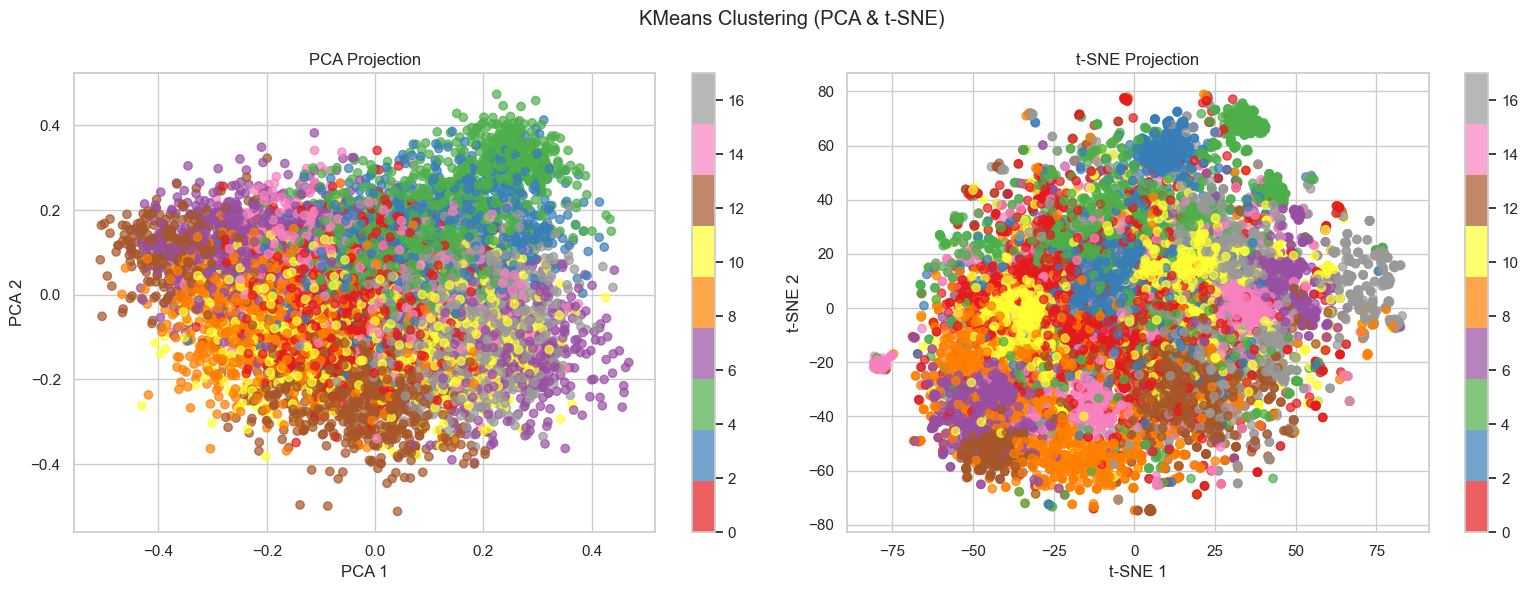

In [12]:
# Visualize the KMeans clustering results with PCA and t-SNE
plot_clusters(emb_norm, df_kmeans["cluster_kmeans"], title="KMeans Clustering (PCA & t-SNE)")

### Save DataFrame with KMeans Clusters

We now save the DataFrame that includes the original metadata and the KMeans cluster assignments.

In [13]:
output_path = "../data/kmeans_results.pkl"
df_kmeans.to_pickle(output_path)
print(f"DataFrame saved to: {output_path}")

excel_output_path = "../data/kmeans_results.xlsx"
with pd.ExcelWriter(excel_output_path, engine="xlsxwriter") as writer:
    df_kmeans.to_excel(writer, sheet_name="All_Clusters", index=False)
    for cluster_id, group in df_kmeans.groupby("cluster_kmeans"):
        sheet_name = f"Cluster_{cluster_id}"
        group.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Excel file saved to: {excel_output_path}")

DataFrame saved to: ../data/kmeans_results.pkl
Excel file saved to: ../data/kmeans_results.xlsx


# Apply DBSCAN Clustering

We apply the DBSCAN clustering algorithm on the normalized embeddings.  
DBSCAN is a density-based clustering method that can automatically detect outliers (labelled as -1) and doesn’t require predefining the number of clusters.  
We set the parameters eps and min_samples based on empirical testing.

In [17]:
df_dbscan = df.copy()

In [14]:
@track_memory_and_time
def search_best_dbscan_params(X, min_samples_list, metric="silhouette"):
    """
    Try different min_samples values, estimate optimal eps using KneeLocator,
    evaluate DBSCAN, and return best parameters and summary dataframe.

    metric: 'silhouette' or 'db_index'
    """
    results = []

    for min_samples in min_samples_list:
        # Step 1: Compute k-distance plot
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(X)
        distances, indices = neighbors_fit.kneighbors(X)
        k_distances = np.sort(distances[:, -1])  # distance to k-th neighbor

        # Step 2: KneeLocator to find eps
        kneedle = KneeLocator(range(1, len(k_distances) + 1), k_distances, S=1.0, curve="convex", direction="increasing")
        eps = kneedle.knee_y

        if eps is None:
            print(f"No clear knee found for min_samples={min_samples}. Skipping...")
            continue

        # Step 3: Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X)

        # Step 4: Evaluate only if enough clusters
        if len(set(labels)) > 1 and not (len(set(labels)) == 2 and -1 in labels):
            silhouette = silhouette_score(X, labels)
            db_index = davies_bouldin_score(X, labels)
        else:
            silhouette = None
            db_index = None

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        results.append({
            "min_samples": min_samples,
            "eps": round(eps, 4),
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": silhouette,
            "db_index": db_index
        })

    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Find best row
    if not df_results.empty and metric in ["silhouette", "db_index"]:
        valid = df_results[df_results[metric].notna()]
        if not valid.empty:
            if metric == "silhouette":
                best_row = valid.loc[valid[metric].idxmax()]
            else:  # db_index
                best_row = valid.loc[valid[metric].idxmin()]

            eps_optimal = best_row["eps"]
            min_samples_optimal = best_row["min_samples"]
            print(f"\nBest DBSCAN parameters based on {metric}:")
            print(f"   ➤ eps = {eps_optimal}")
            print(f"   ➤ min_samples = {min_samples_optimal}")
        else:
            eps_optimal = None
            min_samples_optimal = None
            print("No valid clustering configurations for evaluation.")
    else:
        eps_optimal = None
        min_samples_optimal = None
        print("No results or invalid metric provided.")

    return df_results, eps_optimal, min_samples_optimal

In [15]:
min_samples_list = range(1,101)

In [16]:
df_dbscan_results, eps_optimal, min_samples_optimal = search_best_dbscan_params(emb_norm, min_samples_list=min_samples_list, metric="silhouette")
display(df_dbscan_results)


Best DBSCAN parameters based on silhouette:
   ➤ eps = 1.0618
   ➤ min_samples = 2.0
Time: 140.39 seconds | Peak memory: 2558.76 MB


,min_samples,eps,n_clusters,n_noise,silhouette,db_index
0,1,0.0000,10474,1,0.000191,2.780001e-08
1,2,1.0618,2,61,0.047416,4.628891e+00
2,3,1.0789,1,32,NaN,NaN
3,4,1.0874,1,24,NaN,NaN
4,5,1.0828,1,30,NaN,NaN
...,...,...,...,...,...,...
95,96,1.1730,1,0,NaN,NaN
96,97,1.1755,1,0,NaN,NaN
97,98,1.1679,1,0,NaN,NaN
98,99,1.1815,1,0,NaN,NaN


In [18]:
@track_memory_and_time
def run_dbscan_clustering(X, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X)
    return labels

# Run DBSCAN
dbscan_labels = run_dbscan_clustering(emb_norm, eps=eps_optimal, min_samples=int(min_samples_optimal))

# Assign to dataframe
df_dbscan["cluster_dbscan"] = dbscan_labels

# Check basic cluster stats
print("Number of clusters found (excluding noise):", len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0))
print("Number of noise points (label -1):", (dbscan_labels == -1).sum())
print(df_dbscan["cluster_dbscan"].value_counts().sort_index())

Time: 0.58 seconds | Peak memory: 33.16 MB
Number of clusters found (excluding noise): 2
Number of noise points (label -1): 61
cluster_dbscan
-1       61
 0    10413
 1        2
Name: count, dtype: int64


### Inspect DBSCAN Clusters

Let’s look at a few clusters found by **DBSCAN** and inspect some sample games from each cluster.  
We display the name, summary, genres, and platforms to evaluate the internal coherence of the clusters.  
Note that cluster -1 corresponds to **noise points**, i.e., games that were not assigned to any cluster.

In [19]:
inspect_clusters(df_dbscan, cluster_col="cluster_dbscan")

Cluster -1 — 61 games


,name,summary,genres,platforms
498,Ignis Dei,"Heralded by a comet, seen as a harbinger of do...","Adventure, Indie",PC (Microsoft Windows)
1271,Geezer Gus: The Meteorite Motel,The Meteorite Motel is a surreal JRPG based up...,Role-playing (RPG),PC (Microsoft Windows)
8896,Napoleon: Total War - The Peninsular Campaign,The Peninsular Campaign Downloadable Content i...,Strategy,"Mac, PC (Microsoft Windows)"
5779,Invasion: Family Ties,"Rick travels to Indiana to visit his mother, b...",Adventure,PC (Microsoft Windows)
3374,Millivolt,You play as an electrical appliance repair rob...,"Adventure, Indie, Platform, Puzzle, Strategy",PC (Microsoft Windows)


Cluster 0 — 10413 games


,name,summary,genres,platforms
958,Wave Break,Grab and grind to your heart's content in Wave...,"Arcade, Indie, Shooter, Simulator, Sport","Google Stadia, Linux, Nintendo Switch, PC (Mic..."
4748,Yello Bandana,"Well, there is only one character in this game...",Indie,PC (Microsoft Windows)
8391,Pixel Traffic: Risky Bridge,Drive your car and get to the end of the bridg...,"Indie, Racing","Linux, Mac, PC (Microsoft Windows)"
10394,Cyrah's Ascent,Cyrah's Ascent is a third-person combat game w...,"Adventure, Indie",PC (Microsoft Windows)
4827,My boss is weird,"""My boss is weird"" is a career AVG choice play...",Indie,PC (Microsoft Windows)


Cluster 1 — 2 games


,name,summary,genres,platforms
3981,FourChords Guitar Karaoke,"The fast, easy way to play the songs you love ...","Indie, Simulator","Mac, PC (Microsoft Windows)"
930,Mason and Strings,Mason needs Strings' help to learn how to play...,"Adventure, Indie","Mac, PC (Microsoft Windows)"


### Evaluate DBSCAN Clustering

We evaluate the **DBSCAN** clusters using two standard clustering quality metrics:

- **Silhouette Score**: Indicates how well-separated the clusters are. Higher is better. Range: [-1, 1]
- **Davies–Bouldin Index**: Measures intra-cluster similarity. Lower is better.

Keep in mind that **cluster -1** corresponds to noise (outliers), and is excluded from cluster quality evaluation.

In [20]:
evaluate_clustering(emb_norm, df_dbscan["cluster_dbscan"])

Silhouette Score: 0.0474
Davies–Bouldin Index: 4.6289


### Visualize DBSCAN Clustering

To better understand the structure of the DBSCAN clusters, we project the high-dimensional embeddings into 2D using both **PCA** and **t-SNE**.  
Each point is colored based on its assigned DBSCAN cluster.  
Note that points labeled as **-1** are considered outliers by DBSCAN and appear as a separate group.

Plot saved to: ../data/dbscan_clustering_(pca_&_t-sne).png


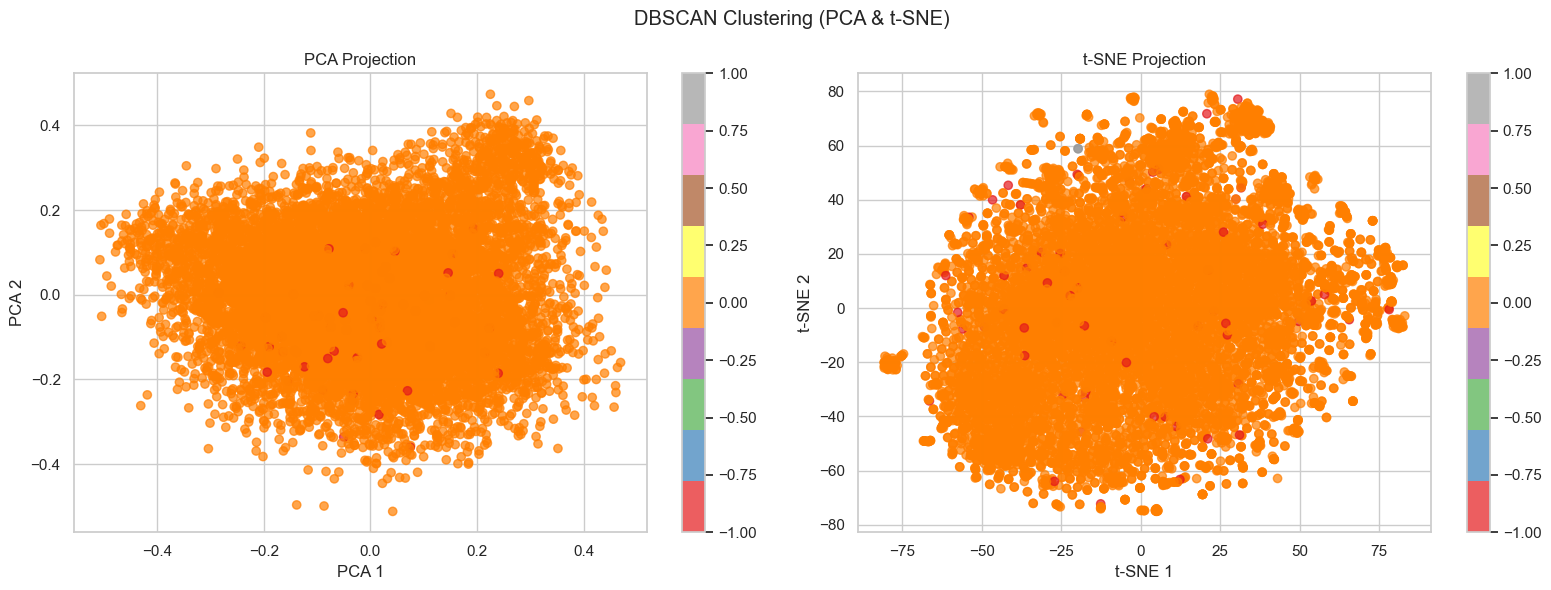

In [21]:
plot_clusters(emb_norm, df_dbscan["cluster_dbscan"], title="DBSCAN Clustering (PCA & t-SNE)")

### Save DataFrame with DBSCAN Clusters

We now save the DataFrame that includes the original metadata and the DBSCAN cluster assignments.

In [22]:
output_path = "../data/dbscan_results.pkl"
df_dbscan.to_pickle(output_path)
print(f"DataFrame saved to: {output_path}")

excel_output_path = "../data/dbscan_results.xlsx"
with pd.ExcelWriter(excel_output_path, engine="xlsxwriter") as writer:
    df_dbscan.to_excel(writer, sheet_name="All_Clusters", index=False)
    for cluster_id, group in df_dbscan.groupby("cluster_dbscan"):
        sheet_name = f"Cluster_{cluster_id}"
        group.to_excel(writer, sheet_name=sheet_name, index=False)
print(f"Excel file saved to: {excel_output_path}")

DataFrame saved to: ../data/dbscan_results.pkl
Excel file saved to: ../data/dbscan_results.xlsx
